In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
sns.set(style="darkgrid")
import sys

ImportError: Traceback (most recent call last):
  File "/Users/davidboyker/miniconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 18, in swig_import_helper
    fp, pathname, description = imp.find_module('_pywrap_tensorflow_internal', [dirname(__file__)])
  File "/Users/davidboyker/miniconda3/lib/python3.6/imp.py", line 297, in find_module
    raise ImportError(_ERR_MSG.format(name), name=name)
ImportError: No module named '_pywrap_tensorflow_internal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/davidboyker/miniconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/Users/davidboyker/miniconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/Users/davidboyker/miniconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 20, in swig_import_helper
    import _pywrap_tensorflow_internal
ModuleNotFoundError: No module named '_pywrap_tensorflow_internal'


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [2]:
def get_y(x):
    return x*x*x

def create_sample_data(size):
    data = []
    x = 100*(np.random.random_sample(size)-0.5)
    for i in range(0, size):
        data.append([x[i], get_y(x[i])])
    return np.array(data)

data = create_sample_data(100)

def create_random_noise(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

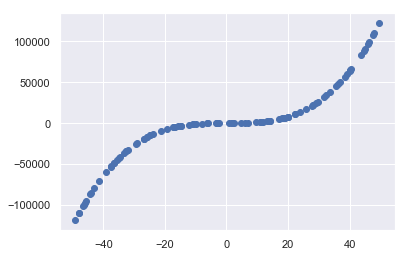

In [3]:
frame = pd.DataFrame(data)
x = frame[0].tolist()
y = frame[1].tolist()
plt.plot(x, y, 'o')
plt.show()

In [ ]:
# Z: placeholder for random samples
# hsize: array containing the sizes of the hidden layers
# reuse: ?
# out: two dimensional vector (generated sample from the distribution)
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)
    return out

# X: placeholder for real or fake samples
# hsize: same as for generator
# out: logit prediction for the given X
def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3

# Placeholders for the random samples and real sample
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

# Generating samples and feeding samples to the discriminator
G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

# Loss functions
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

# Optimizers and learning rates
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")
gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step

# Training
# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10
x_plot = create_sample_data(batch_size)
f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')
dlosses = []
glosses = []
for i in range(100001):
    X_batch = create_sample_data(batch_size)
    Z_batch = create_random_noise(batch_size, 2)
   
    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
        rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})
    if i % 10 == 0:
        dlosses.append(dloss)
        glosses.append(gloss)
        f.write("%d,%f,%f\n"%(i,dloss,gloss))
    if i % 1000 == 0:
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])
        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('training-gan/iteration_%d.png'%i)
        plt.close()
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
    sns.lineplot(data=pd.DataFrame({0:glosses, 1:dlosses}))
f.close()